# Predicting the Sale Price of Bulldozers using Machine Learning

In this notebook, we are going to go through an example ML project with the goal of predicitng the sales price of bulldozers.

## 1. Problem definition

> How well can we predict the future sales price of a bulldozer given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data

> The data is downloaded from Kaggle Bulldozers competition.

There are 3 main datatsets:
* Train set
* Validation set
* Test set

## 3. Evaluation

The evaluatoin metric for this competition is the RMSLE (root mean squred log error) between the actual and predicted auction prices.

The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project is to build a ML model that minimizes RMSLE.

## 4. Features
You can view the data dictionary on Google sheets: https://docs.google.com/spreadsheets/d/1HCuYOGgQxelSfoYIycpkmV1g6EZ7f3_R/edit?usp=sharing&ouid=111617277914745417208&rtpof=true&sd=true

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv('../data/bluebook-for-bulldozers/TrainAndValid.csv', low_memory=False)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [7]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

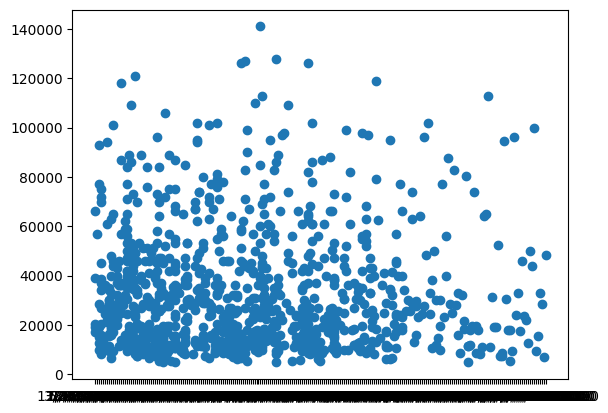

In [10]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000]);

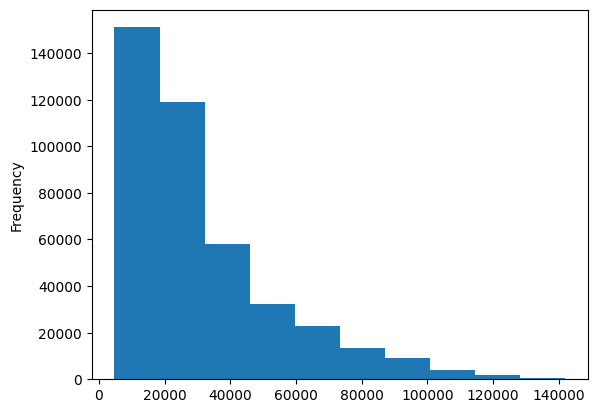

In [12]:
df.SalePrice.plot.hist();

### Parsing dates
 When we work with time series data, we want to enrigh the time and date component as much as possible. We can do that by telling Pandas which of our columns has dates in it by using the `parse_dates` parameter.

In [14]:
#  Import data again but this parse dates

df = pd.read_csv('../data/bluebook-for-bulldozers/TrainAndValid.csv', 
                 low_memory=False, 
                 parse_dates=['saledate'])
df.saledate.dtype

dtype('<M8[ns]')

In [15]:
df.saledate.head(3)

0   2006-11-16
1   2004-03-26
2   2004-02-26
Name: saledate, dtype: datetime64[ns]

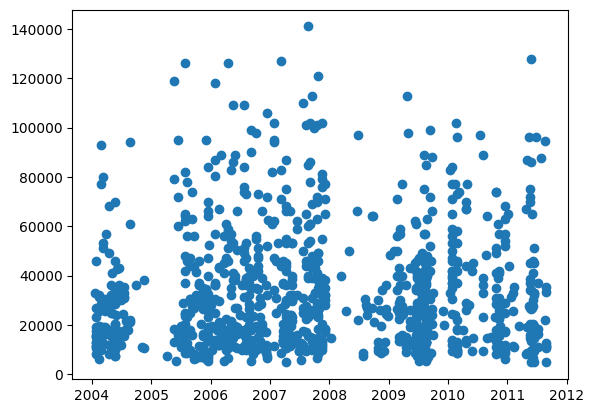

In [16]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000]);

In [19]:
df.saledate.head()

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
Name: saledate, dtype: datetime64[ns]

### Sort DF by saledate

When working with Time Series data, it's a good idea to sort by date.

In [20]:
# Sort DF in date order

df.sort_values(by=['saledate'], inplace=True, ascending=True)
df.saledate.head()

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of original df

We make a copy of the original dataframe so when we manipulate the copy, we've still got our originla data.

In [132]:
# Make a copy
df_tmp = df.copy()

### Add datetime parameters for `saledate` column 

In [133]:
df_tmp['saleYear'] = df_tmp['saledate'].dt.year
df_tmp['saleMonth'] = df_tmp['saledate'].dt.month
df_tmp['saleDay'] = df_tmp['saledate'].dt.day
df_tmp['saleDayOfWeek'] = df_tmp['saledate'].dt.dayofweek
df_tmp['saleDayOfYear'] = df_tmp['saledate'].dt.dayofyear

In [134]:
df_tmp.drop('saledate', axis=1, inplace=True)

In [135]:
# Helps to check the spread of data
df_tmp['state'].value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

### Convert strings to categories

One way we can turn all of our data into numbers is by converting them into Pandas categories.

We can check all the data types compatible with Pandas here:
https://pandas.pydata.org/pandas-docs/version/1.4/reference/api/pandas.api.types.is_object_dtype.html

In [136]:
 pd.api.types.is_string_dtype(df_tmp['state'])

True

In [137]:
# find the string coloumns

for label, content in df_tmp.items():
    label_is_string = pd.api.types.is_string_dtype(content)
    if label_is_string:
        df_tmp[label] = content.astype('category').cat.as_ordered()

In [138]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [139]:
# numerical code given to all string values that were converted to categories
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

In [140]:
# Check missing data
df_tmp.isnull().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

### Save preprocessed data to csv

In [141]:
# Export current tmp dataframe
df_tmp.to_csv('../data/bluebook-for-bulldozers/train_tmp.csv',
             index=False)

In [220]:
# Import preprocessed data
df_tmp = pd.read_csv('../data/bluebook-for-bulldozers/train_tmp.csv',
                    low_memory=False)
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
0,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
1,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
2,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
3,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
4,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31


## Fill missing values

### FIlling and turning categorical variables into numbers

In [221]:
# find the non-numeric coloumns

for label, content in df_tmp.items():
    label_is_num = pd.api.types.is_numeric_dtype(content)
    if not label_is_num:
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        df_tmp[label] = pd.Categorical(content).codes + 1

In [222]:
# All missing values on-numeric have been filled
df_tmp.isna().sum().head(20)

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                        0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc                  0
fiModelSeries                    0
fiModelDescriptor                0
ProductSize                      0
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                     0
dtype: int64

In [223]:
df_tmp.head(3)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,0,4593,...,True,True,True,True,True,False,False,False,True,True
1,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,0,1820,...,True,True,True,True,True,True,True,True,False,False
2,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,0,2348,...,True,True,True,True,True,False,False,False,True,True




### Fill numerical missing values on split train and test data

In [224]:
# Split data into training and testing sets
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val), len(df_train)


(11573, 401125)

In [225]:
# find the numeric coloumns for train and test sets

for label, content in df_train.items():
    label_is_num = pd.api.types.is_numeric_dtype(content)
    if label_is_num:
        # Check for which numerical value have null values
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing
            df_train[label+"_is_missing"] = pd.isnull(content)
            # Fill the numeric rows with null values with the median
            df_train[label] = content.fillna(content.median())

/var/folders/xw/066_bkcs2sd0ylsjpzsd5gk40000gn/T/ipykernel_56907/2176505336.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[label+"_is_missing"] = pd.isnull(content)
/var/folders/xw/066_bkcs2sd0ylsjpzsd5gk40000gn/T/ipykernel_56907/2176505336.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[label] = content.fillna(content.median())
/var/folders/xw/066_bkcs2sd0ylsjpzsd5gk40000gn/T/ipykernel_56907/2176505336.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [226]:
for label, content in df_val.items():
    label_is_num = pd.api.types.is_numeric_dtype(content)
    if label_is_num:
        # Check for which numerical value have null values
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing
            df_val[label+"_is_missing"] = pd.isnull(content)
            # Fill the numeric rows with null values with the median
            df_val[label] = content.fillna(content.median())

/var/folders/xw/066_bkcs2sd0ylsjpzsd5gk40000gn/T/ipykernel_56907/1060024180.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val[label+"_is_missing"] = pd.isnull(content)
/var/folders/xw/066_bkcs2sd0ylsjpzsd5gk40000gn/T/ipykernel_56907/1060024180.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val[label] = content.fillna(content.median())


In [227]:
# Check if there's any null numerical values

for label, content in df_train.items():
    label_is_num = pd.api.types.is_numeric_dtype(content)
    if label_is_num:
        if pd.isnull(content).sum():
            print(label)

In [228]:
for label, content in df_train.items():
    label_is_num = pd.api.types.is_numeric_dtype(content)
    if label_is_num:
        if pd.isnull(content).sum():
            print(label)

In [229]:
# CHeck to see if binary coluns are correct
df_train.auctioneerID_is_missing.value_counts()

False    380989
True      20136
Name: auctioneerID_is_missing, dtype: int64

In [236]:
df_val['auctioneerID_is_missing'] = False
df_val.auctioneerID_is_missing[:5]

/var/folders/xw/066_bkcs2sd0ylsjpzsd5gk40000gn/T/ipykernel_56907/3352439313.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['auctioneerID_is_missing'] = False


401125    False
401126    False
401127    False
401128    False
401129    False
Name: auctioneerID_is_missing, dtype: bool

## 5. Modeling

We've done enough EDA (we could always do more) but let's start to do some model-driven EDA now that the dataframe has no missing values and all the data is numeric.

ML map to choose the right estimator: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

RandomForestRegressor model: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor

### Splitting data into train/validation sets

In [260]:
df_tmp.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [261]:
# Split data into X and y
X_train, y_train = df_train.drop('SalePrice', axis=1), df_train['SalePrice']

X_valid, y_valid = df_val.drop('SalePrice', axis=1), df_val['SalePrice']

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

In [262]:
y_train

0          9500.0
1         14000.0
2         50000.0
3         16000.0
4         22000.0
           ...   
401120    29000.0
401121    11000.0
401122    11000.0
401123    18000.0
401124    13500.0
Name: SalePrice, Length: 401125, dtype: float64

## Building an evaluation function

In [263]:
# Create evaluation function (RMSLE needs to be used)
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, r2_score

def rmsle(y_test, y_preds):
    '''
    Calculate root mean swuared log error
    between prediction and true label.
    '''
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {'Training MAE': mean_absolute_error(y_train, train_preds),
             'Valid MAE': mean_absolute_error(y_valid, val_preds),
             'Training RMSLE': rmsle(y_train, train_preds),
             'Valid RMSLE': rmsle(y_valid, val_preds),
             'Training R^2': r2_score(y_train, train_preds),
             'Valid R^2': r2_score(y_valid, val_preds)}
    return scores

# Testing our model on a subset (to tune the hyperparameters)


In [264]:
# Change max_samples value
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, # Use as many cores as possible from computers since data is huge
                             random_state=42,
                             max_samples=10000)

model.fit(X_train, y_train)

RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [265]:
show_scores(model)

/Users/kathytavia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


{'Training MAE': 5562.095336615769,
 'Valid MAE': 7199.28606411475,
 'Training RMSLE': 0.25769905315247876,
 'Valid RMSLE': 0.2944661103258922,
 'Training R^2': 0.8605542549153568,
 'Valid R^2': 0.8324603639791454}

### Hyperparameter tuning with RandomizedSearchCV

In [271]:
## from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

rf_grid = {'n_estimators': np.arange(10,100,10),
        'max_depth':[None,3,5,10],
        'min_samples_split': np.arange(2,20,2),
        'min_samples_leaf': np.arange(1,20,2),
        'max_features':[0.5, 1, 'sqrt', 'auto'],
        'max_samples': [10000]}

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42),
                                   param_distributions=rf_grid,
                               cv=5,
                               n_iter=2,
                               verbose=True)
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [272]:
# Now we cna find the best hyperameters
rs_model.best_params_

{'n_estimators': 80,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_samples': 10000,
 'max_features': 'sqrt',
 'max_depth': 10}

In [273]:
# Evaluate the RS model
show_scores(rs_model)

/Users/kathytavia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


{'Training MAE': 9013.430271376057,
 'Valid MAE': 10443.794432961085,
 'Training RMSLE': 0.3954054072441339,
 'Valid RMSLE': 0.41915857910924137,
 'Training R^2': 0.6782585508395402,
 'Valid R^2': 0.6909545872055323}

### Train the model with the best hyperparameter on full data set

Note: These were found after 100 n_iters of RandomizedSearchCV

In [276]:
from sklearn.ensemble import RandomForestRegressor

ideal_model = RandomForestRegressor(n_jobs=-1, # Use as many cores as possible from computers since data is huge
                             random_state=42,
                             n_estimators=40,
                             min_samples_split=14,
                             min_samples_leaf=1,
                             max_samples=None,
                             max_features=0.5)

ideal_model.fit(X_train, y_train)

RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [278]:
# Scores on ideal model (trained on all the data)
show_scores(ideal_model)

/Users/kathytavia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


{'Training MAE': 2958.525694860444,
 'Valid MAE': 5989.113813477665,
 'Training RMSLE': 0.14484724514847727,
 'Valid RMSLE': 0.2479702912385731,
 'Training R^2': 0.9587093056181626,
 'Valid R^2': 0.8804970871683779}

In [279]:
# Scores on rs model (trained on 10,000 examples)
show_scores(rs_model)

/Users/kathytavia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


{'Training MAE': 9013.430271376055,
 'Valid MAE': 10443.794432961085,
 'Training RMSLE': 0.3954054072441339,
 'Valid RMSLE': 0.41915857910924137,
 'Training R^2': 0.6782585508395402,
 'Valid R^2': 0.6909545872055323}

## Use `ideal_model` to make predictions on test data

In [281]:
# Import test data
test_df = pd.read_csv('../data/bluebook-for-bulldozers/Test.csv', 
                      low_memory=False,
                     parse_dates=['saledate'])

test_df.head(3)

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN


### Preprocessing the data (getting the test data in the same format as our training dataset)

In [282]:
def preprocessing_test_data(df):
    '''
        Performs transformation on df and returns transformed df.
    '''
    #Add new coulmns
    df['saleYear'] = df['saledate'].dt.year
    df['saleMonth'] = df['saledate'].dt.month
    df['saleDay'] = df['saledate'].dt.day
    df['saleDayOfWeek'] = df['saledate'].dt.dayofweek
    df['saleDayOfYear'] = df['saledate'].dt.dayofyear
    
    df.drop('saledate', axis=1, inplace=True)    
       
    # find the numeric coloumns for train and test sets
    for label, content in df.items():
        label_is_num = pd.api.types.is_numeric_dtype(content)
        if label_is_num:
            # Check for which numerical value have null values
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill the numeric rows with null values with the median
                df[label] = content.fillna(content.median())
        # find the non-numeric coloumns
        else:
            df[label+"_is_missing"] = pd.isnull(content)
            df[label] = pd.Categorical(content).codes + 1
            
    return df

In [283]:
test_df = preprocessing_test_data(test_df)
test_df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [285]:
# Check for any remaining values          
for label, content in test_df.items():
    label_is_num = pd.api.types.is_numeric_dtype(content)
    if label_is_num:
        if pd.isnull(content).sum():
            print(label)

In [286]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing,MachineHoursCurrentMeter_is_missing
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,False,False,False,True,True,False,True
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,False,False,False,True
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,False,False,False,True,True,False,True
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,False,False,False,True
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,False,False,False,True,True,False,True


 Our `test_df` and `X_train` data have different column count so cannot make predictions without finding the missing column

# Make predictions on updated test data

In [287]:
# We can find how the columns differ using python sets
set(X_train.columns) - set(test_df.columns)

{'auctioneerID_is_missing'}

In [288]:
# We can manually update this missing column with False as values
test_df['auctioneerID_is_missing'] = False

Finally now the test dataframe has the same features as training dataframe, so we can make predictions now!

In [289]:
# Make prediction on test data
test_preds = ideal_model.predict(test_df)

/Users/kathytavia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [290]:
test_preds

array([17699.40283986, 15323.48268964, 51178.31732513, ...,
       13646.28034948, 18972.42792312, 25595.19590287])

In [291]:
# Format predictions into same format Kaggle wants
df_preds = pd.DataFrame()
df_preds['SalesID'] = test_df['SalesID']
df_preds['SalePrice'] = test_preds
df_preds.head()

,SalesID,SalePrice
0,1227829,17699.402840
1,1227844,15323.482690
2,1227847,51178.317325
3,1227848,62016.373917
4,1227863,47597.489432


In [292]:
# Export prediction data to csv
df_preds.to_csv('../data/bluebook-for-bulldozers/test_predictions.csv', index=False)

# Feature importance

Feature importance seeks to figure out whch different attributes of the data were most important when it comes to predicting the **target variable** (SalePrice).

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [294]:
# Find feature importance
ideal_model.feature_importances_

array([3.51586239e-02, 1.97748915e-02, 4.27606681e-02, 1.90613314e-03,
       3.27463962e-03, 2.00566731e-01, 3.22413890e-03, 9.85267576e-04,
       4.18931247e-02, 4.12083250e-02, 5.85903765e-02, 5.03002146e-03,
       1.67465985e-02, 1.35160647e-01, 4.78636632e-02, 5.92562512e-03,
       6.14735201e-03, 2.85439154e-03, 2.52573440e-03, 7.88450568e-02,
       4.21322981e-04, 5.24705610e-05, 1.50466818e-03, 1.87321771e-04,
       1.60328985e-03, 2.33144276e-05, 6.08490143e-03, 4.24131965e-03,
       2.29797041e-03, 2.97001329e-04, 2.17585157e-03, 1.63181193e-03,
       3.43030065e-03, 5.21618040e-04, 2.76700679e-04, 1.11879269e-02,
       8.16204101e-04, 1.44301025e-02, 1.94922078e-03, 1.35713882e-03,
       8.54963616e-04, 8.40145068e-04, 1.17918748e-03, 5.59509850e-04,
       5.79062374e-04, 3.59684011e-04, 2.72938291e-04, 2.41085143e-03,
       8.67104315e-04, 2.33938693e-04, 1.54600792e-04, 7.38865439e-02,
       3.71810242e-03, 5.68797343e-03, 2.91434259e-03, 9.91372727e-03,
      

In [297]:
# Helper for plotting feature importance

def plot_features(columns,importances, n=20):
    df = (pd.DataFrame({'features': columns,
                       'feature_importances': importances})
          .sort_values('feature_importances', ascending=False)
          .reset_index(drop=True))
          
    # Plot df created
    fig, ax = plt.subplots()
    ax.barh(df['features'][:n], df['feature_importances'][:20])
    ax.set_ylabel('Features')
    ax.set_xlabel('Features importance')
    ax.invert_yaxis()

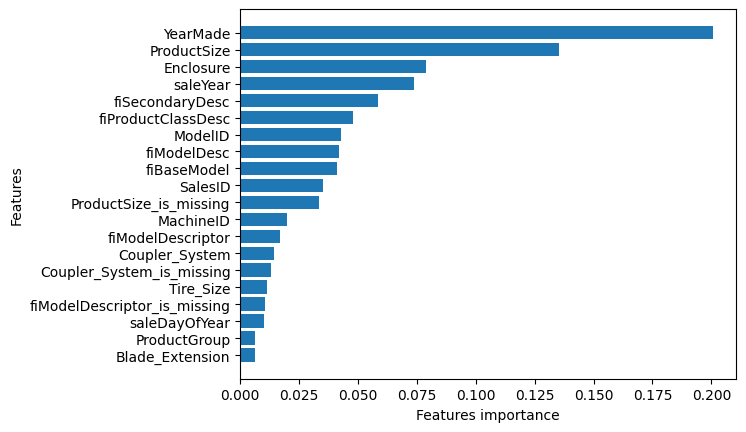

In [298]:
plot_features(X_train.columns,ideal_model.feature_importances_)